# Semantic segmentation with Deep Learning

Chaitanya Krishna VIRIYALA

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Introduction

For quantitative analysis, cells in microscopic images need to be segmented from the image. In this notebook we will model the problem in terms of semantic segmentation and approach it by means of deep learning, and more specifically with the U-Net architecture.

### 1. Load modules and data

#### 1.1 Import modules

In [2]:
#4S
# Import all the necessary libraries
import os
import datetime 
import glob                                           #filename pattern matching
import random
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#SKIMAGE
import skimage.io                                     #Used for imshow function
import skimage.transform                              #Used for resize function
import skimage.exposure                               #Used for displaying 

#Tensorflow, Keras and related modules
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import add, concatenate
#from keras.layers import LeakyReLU


#To save and reload models
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.utils import  plot_model
#from tensorflow.keras.utils import multi_gpu_model

#For data augmentation
from keras.preprocessing.image import ImageDataGenerator    
from keras.callbacks import EarlyStopping, ModelCheckpoint

#Sklearn 
import sklearn
from sklearn.model_selection import train_test_split

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Skimage      :', skimage.__version__)
print('Scikit-learn :', sklearn.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.6.9 (default, Oct  8 2020, 12:12:24) 
Numpy        : 1.19.5
Skimage      : 0.16.2
Scikit-learn : 0.22.2.post1
Tensorflow   : 2.4.1


#### 1.2 Define global parameters
- Set seed for random values to a fix number (42) to ensure that we get images and masks that correspond to each other. 


In [3]:
#4S
# Set seed values
seed = 42
random.seed = seed
np.random.seed(seed=seed)

# Set number of GPUs
#num_gpus = 1   #defaults to 1 if one-GPU or one-CPU. If 4 GPUs, set to 4.

# Set height (y-axis length) and width (x-axis length) to train model on
img_height, img_width = (64,64)  #Default to (256,266), use (None,None) if you do not want to resize imgs

#### 1.3.1 Define the data path
Define the data path and change the directory to the defined topDir. Also specify the train and test directories

In [4]:
#4S
topDir = "/content/drive/MyDrive/DATA/"
inormin = 'input'
os.chdir(topDir)    
print(os.listdir(os.path.join(topDir, 'mini-input')))  #see what's in the input folder (where data is in)
train_path = os.path.join(topDir, 'mini-input/stage1_train')  #path to training data file/folder
test_path = os.path.join(topDir, 'mini-input/stage1_test')   #path to test data file/folder

['stage1_test', 'stage1_train']


#### 1.3.2 Read and preload the input image data
Read the data and create a tensor containing all the train and test data as well as their corresponding labels.

The following function ``get_images``  
- receives as input an image path (can be train or test), and a desired image shape for the output
- lists all files in the input image path. Hint: use ``os.listdir``.
- reads each of the files with ``skimage.io.imread``
- uses ``skimage.transform.resize`` to directly downsample the images according to the ``img_height, img_width`` parameters.
- uses only the first three channels of the images.
- returns a numpy array (matrix) . 
- uses ``%%time`` to display the time spent in loading.
- Runs the function and print the shape and type of the resulting array (e.g. (670, 256, 256, 3) uint8 

In [5]:
%%time
# Get training data
def get_images(path, output_shape=(None, None)):
    '''
    Loads images from path/{id}/images/{id}.png into a numpy array
    '''
    img_paths = ['{0}/{1}/images/{1}.png'.format(path, id) for id in os.listdir(path) if id != ".DS_Store"]

    #X_data = np.array([skimage.io.imread(path)[:,:,:3] for path in img_paths], dtype=np.uint8)  #take only 3 channels/bands

    X_data = np.array([skimage.transform.resize(skimage.io.imread(path)[:,:,:3], output_shape=output_shape, mode='constant', preserve_range=True) for path in img_paths], dtype=np.uint8)  #take only 3 channels/bands
    
    return X_data
X_train = get_images(train_path, output_shape=(img_height,img_width))
print(X_train.shape, X_train.dtype)
    


(50, 64, 64, 3) uint8
CPU times: user 2.13 s, sys: 1.37 s, total: 3.5 s
Wall time: 2.06 s


#### 1.3.3 Read and preload the anotations
The following function ``get_labels``  
- receives as input a mask path (can be train or test), and a desired image shape for the output.
- lists all files in the input path. Hint: use ``os.listdir``.
- reads each of the files with ``skimage.io.imread``
- uses ``skimage.transform.resize`` to directly downsample the masks according to the ``img_height, img_width`` parameters.
- returns a numpy array (matrix) . 
- uses ``%%time`` to display the time spent in loading.
- Runs the function and print the shape and type of the resulting array (e.g. (670, 256, 256, 3)) uint8 
- This can take some minutes (reduce the number of images to accelerate the first tests and reduce memory demands if necessary)

In [6]:
%%time
# Get training data labels
def get_labels(path, output_shape=(None, None)):
    '''
    Loads and concatenates images from path/{id}/masks/{id}.png into a numpy array
    '''
    img_paths = [glob.glob('{0}/{1}/masks/*.png'.format(path, id)) for id in os.listdir(path) if id != ".DS_Store"]
    
    Y_data = []
    for i, img_masks in enumerate(img_paths):  #loop through each individual nuclei for an image and combine them together
        masks = skimage.io.imread_collection(img_masks).concatenate()  #masks.shape = (num_masks, img_height, img_width)
        mask = np.max(masks, axis=0)                                   #mask.shape = (img_height, img_width)
        mask = skimage.transform.resize(mask, output_shape=output_shape+(1,), mode='constant', preserve_range=True)  #need to add an extra dimension so mask.shape = (img_height, img_width, 1)
        Y_data.append(mask)

    # make sure to return the binary images but coded as floats to be compatible with the loss functions
    Y_data = np.array(Y_data, dtype=np.bool)
    
    return Y_data    
    
Y_train = get_labels(train_path, output_shape=(img_height,img_width))

print("We have {} labeled images of size ({},{}) and type {}".format(Y_train.shape[0],Y_train.shape[1],Y_train.shape[2],Y_train.dtype))




We have 50 labeled images of size (64,64) and type bool
CPU times: user 4.94 s, sys: 4.53 s, total: 9.47 s
Wall time: 10.1 s


In [7]:
Y_train =1.0*Y_train.astype(float)

In [8]:
# We split the original train data into new train data(40 images) and test data(10 images)
X_train, X_test, Y_train, Y_test = train_test_split(X_train,Y_train,test_size=0.2,random_state=0)

#### 1.4 Visualize some examples of images and matching labels
Choose one index among the lists of images and labels and use ``plt.imshow`` to visualize side by side the corresponding image and mask.
You may want to use ```skimage.exposure.rescale_intensity``` for better visualization of the input.

Looking at image  38
(40, 64, 64, 1)


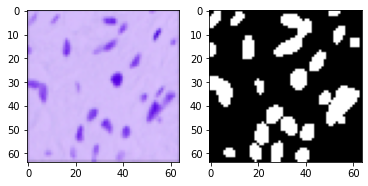

In [9]:
%matplotlib inline

idx = np.random.randint(Y_train.shape[0], size=1)[0]

print ('Looking at image ', idx)

fig, axis = plt.subplots(nrows = 1, ncols = 2)

print(Y_train.shape)

axis[0].imshow(skimage.exposure.rescale_intensity(X_train[idx, :, :, :]))
axis[1].imshow(np.reshape(Y_train[idx, :, :, :], (Y_train.shape[1], Y_train.shape[2])),cmap='gray') #why 3 spaces if ytrain is of different shape, why resize needed?
#axis[1].imshow(Y_train[idx, :, :],cmap='gray')

### 2. Buidling the U-Net model
#### 2.1. Define the architecture

**a)** Building the model


In [10]:
# Design our model architecture here
def unet_model(img_width=256, img_height=256):
    
    #define the architecture parameters
    n_channels = [16,32,64,128]  # 256 is not included in the list, the number of kernels/feature channels per block
    k_size = (3, 3)  #size of filter kernel
    k_init = 'he_normal' #kernel initializer
    l_conv1 = [] #list of the first convolutional layers of each encoder block
    l_conv2 = [] #list of the second convolutional layers of each encoder block
    output_enc = [] #list of econder blocks, append here the blocks you want to connect with skip connections
    l_maxpool = [] #list of the maxpool outputs
    l_tconv = [] # list of the ouputs of the transposed convolution

    # Use Keras Input layer to create one
    inp = Input(shape =(img_width,img_height,3)) # (64,64,3)
    x = inp

    # Encoder
    for filters in n_channels:
      x = Conv2D(filters,k_size, padding="same",activation="relu",kernel_initializer=k_init)(x)
      l_conv1.append(x) # (64, 64, 16),(32, 32, 32),(16, 16, 64),(8, 8, 128)
      

      x = Conv2D(filters,k_size, padding="same",activation="relu",kernel_initializer=k_init)(x)
      l_conv2.append(x) # (64, 64, 16),(32, 32, 32),(16, 16, 64),(8, 8, 128)
      output_enc.append(x)
    

      x = MaxPooling2D(pool_size=(2,2),strides=2,padding="same")(x)
      l_maxpool.append(x) # (32, 32, 16) , (16, 16, 32) , (8, 8, 64) , (4, 4, 128)   

    # The deepest block has no pooling layer
    x = Conv2D(256,k_size, padding="same",activation="relu",kernel_initializer=k_init)(x)
    l_conv1.append(x)
    x = Conv2D(256,k_size, padding="same",activation="relu",kernel_initializer=k_init)(x) 
    l_conv2.append(x)
    

    # Decoder
    for i,filters in enumerate(n_channels[::-1]):
      x = Conv2DTranspose(filters,k_size,padding="same",activation="relu",kernel_initializer=k_init,strides=2)(x)
      l_tconv.append(x)
      x = concatenate([output_enc[3-i],l_tconv[i]], axis=-1)
      x = Conv2D(filters,k_size,padding="same",activation="relu",kernel_initializer=k_init)(x)
      x = Conv2D(filters,k_size,padding="same",activation="relu",kernel_initializer=k_init)(x)

    # Output
    
    outp = Conv2DTranspose(1,k_size,padding='same',activation='sigmoid')(x)
    
    #Build Model with the architecture
    model = Model(inputs=[inp], outputs=[outp])
    return model

In [11]:
model = unet_model(img_width,img_height)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 16)   2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 16)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

#### 2.2. Define the losses


In [12]:
import keras
from keras import backend as K 
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.flatten(y_true)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = keras.losses.binary_crossentropy(y_true, y_pred) 
    return loss

def costum_dice_loss(y_true, y_pred):
    #weighted average between binary crossentropy and dice loss
    loss = 0.5*dice_coef(y_true, y_pred) + 0.5*dice_loss(y_true, y_pred)
    return loss


#### 2.3 Define optimizer 

In [13]:
# Set optmizer, loss and metric 
optimizer = 'adam'
loss      = costum_dice_loss
metrics   = [dice_loss]


#### 2.4 Compile the model

Instantiate the model, make a summary of it and compile it


In [14]:
#instantiate the model
model = unet_model(img_width,img_height)

#summary
model.summary()

#compile the model
model.compile(optimizer,loss,metrics)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 64, 64, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 64, 64, 16)   2320        conv2d_18[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 32, 32, 16)   0           conv2d_19[0][0]                  
____________________________________________________________________________________________

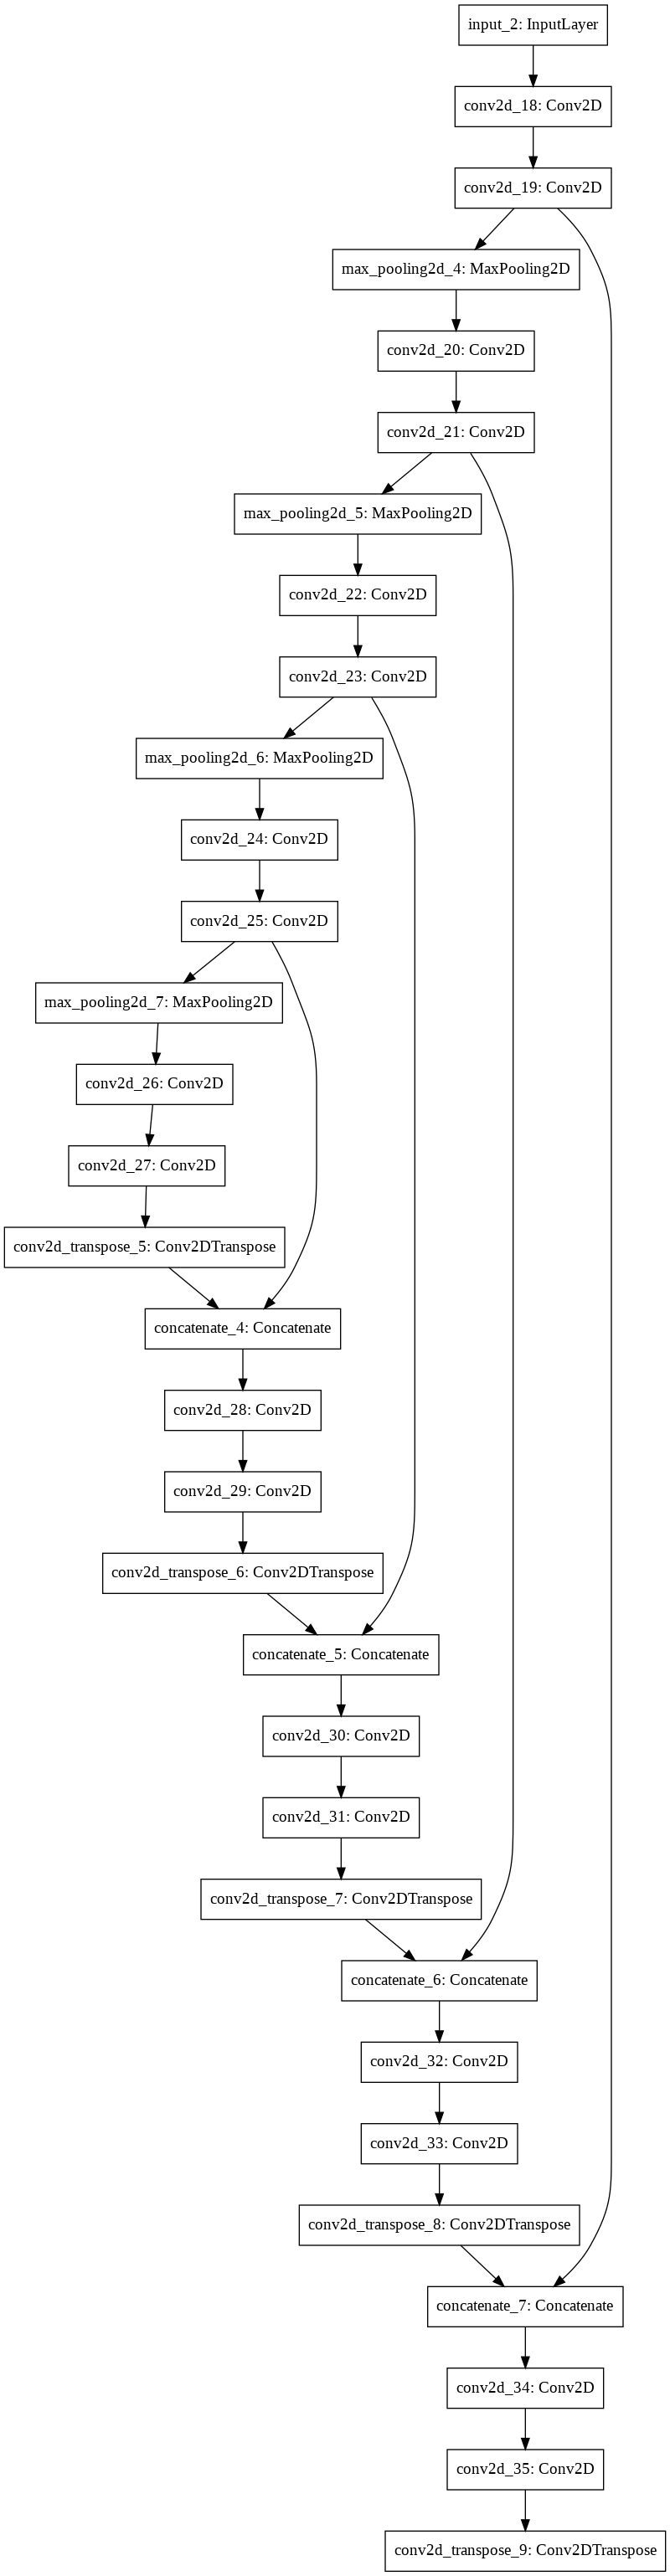

In [15]:
#run the following cell to visualize the created model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

### 3. Trainning and testing

#### 3.1 Launch the training
- Use the ```model.fit``` function to launc the training,  
- Measure the overall time with ```%%time``` at the beginning of the notebook cell


In [16]:
%%time
# Fit model
epochs= 40
batch_size= 25

history = model.fit(X_train,Y_train,batch_size,epochs)


Epoch 1/40
2/2 [==============================] - 4s 334ms/step - loss: 5.8898 - dice_loss: 11.4503
Epoch 2/40
2/2 [==============================] - 0s 14ms/step - loss: 2.3060 - dice_loss: 4.3074
Epoch 3/40
2/2 [==============================] - 0s 15ms/step - loss: 1.6131 - dice_loss: 2.9342
Epoch 4/40
2/2 [==============================] - 0s 15ms/step - loss: 1.2053 - dice_loss: 2.0189
Epoch 5/40
2/2 [==============================] - 0s 14ms/step - loss: 1.0306 - dice_loss: 1.6099
Epoch 6/40
2/2 [==============================] - 0s 14ms/step - loss: 0.8836 - dice_loss: 1.2966
Epoch 7/40
2/2 [==============================] - 0s 15ms/step - loss: 0.8877 - dice_loss: 1.3066
Epoch 8/40
2/2 [==============================] - 0s 15ms/step - loss: 0.8326 - dice_loss: 1.1885
Epoch 9/40
2/2 [==============================] - 0s 14ms/step - loss: 0.7940 - dice_loss: 1.0910
Epoch 10/40
2/2 [==============================] - 0s 14ms/step - loss: 0.7565 - dice_loss: 0.9948
Epoch 11/40
2/2 [

#### 3.2. Save the model
Save the final model ``model_out.save_weights`` with an hdf5 format. You may also find it useful to create a 
checkpoint ``ModelCheckpoint`` of the current best model up to now during training.


In [17]:
model.save_weights('model1_weights.hdf5')

3.3. Plot the history of the loss and the metrics

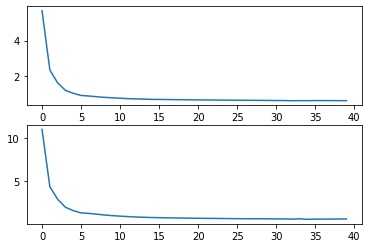

In [18]:
plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.subplot(2,1,2)
plt.plot(history.history['dice_loss'])


#### 3.3. Test
Load the test images, make predictions and visualize the predictions 


In [19]:
#if required reload the model
# model.save_weights('model1_weights.hdf5')

history = model.fit(X_test,Y_test,batch_size,epochs)


Epoch 1/40
1/1 [==============================] - 0s 316ms/step - loss: 0.5756 - dice_loss: 0.5426
Epoch 2/40
1/1 [==============================] - 0s 12ms/step - loss: 0.5745 - dice_loss: 0.5426
Epoch 3/40
1/1 [==============================] - 0s 10ms/step - loss: 0.5727 - dice_loss: 0.5470
Epoch 4/40
1/1 [==============================] - 0s 13ms/step - loss: 0.5707 - dice_loss: 0.5565
Epoch 5/40
1/1 [==============================] - 0s 13ms/step - loss: 0.5688 - dice_loss: 0.5664
Epoch 6/40
1/1 [==============================] - 0s 13ms/step - loss: 0.5660 - dice_loss: 0.5656
Epoch 7/40
1/1 [==============================] - 0s 12ms/step - loss: 0.5623 - dice_loss: 0.5546
Epoch 8/40
1/1 [==============================] - 0s 10ms/step - loss: 0.5586 - dice_loss: 0.5425
Epoch 9/40
1/1 [==============================] - 0s 10ms/step - loss: 0.5546 - dice_loss: 0.5379
Epoch 10/40
1/1 [==============================] - 0s 11ms/step - loss: 0.5500 - dice_loss: 0.5480
Epoch 11/40
1/1 [=

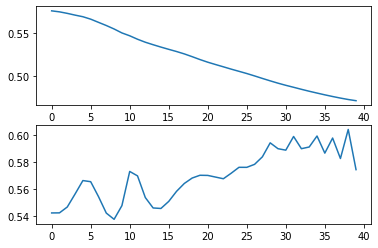

In [20]:
plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.subplot(2,1,2)
plt.plot(history.history['dice_loss'])


In [21]:
print(Y_test.shape)
print(X_test.shape)

(10, 64, 64, 1)
(10, 64, 64, 3)


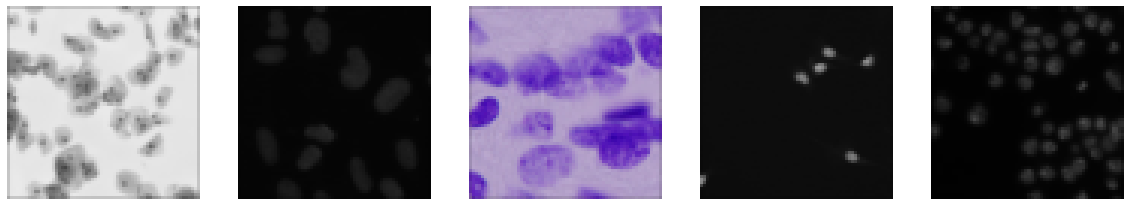

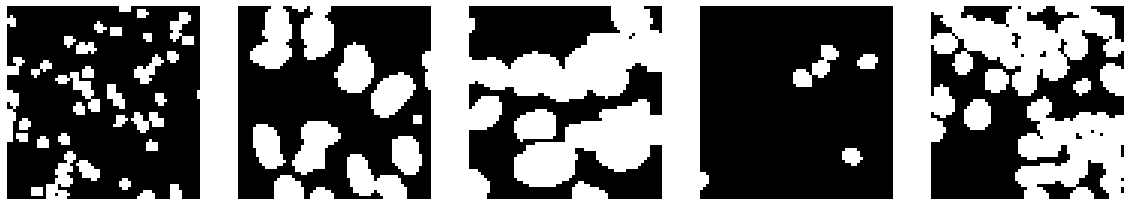

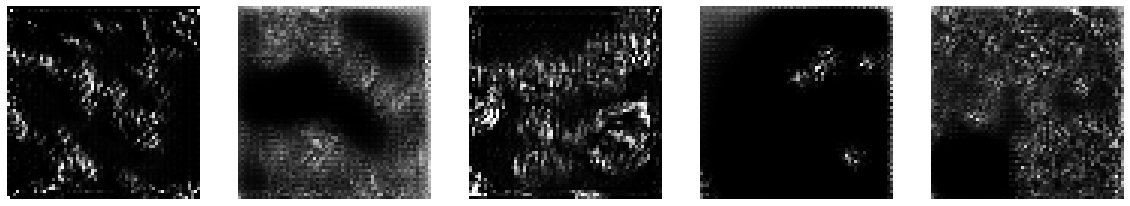

In [22]:
Y_pred = model.predict(X_test)

plt.figure(figsize = (20,20))
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow(X_test[i, :, :, :])
  plt.axis('off')
plt.show() 
plt.figure(figsize = (20,20))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(Y_test[i, :, :, 0],cmap='gray')
  plt.axis('off')
plt.show() 
plt.figure(figsize = (20,20))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(Y_pred[i, :, :, 0],cmap='gray')
  plt.axis('off')
plt.show()   
 


### 4 Comparison and Improvement

The following things have been made :
- Change the architecture (use the one from the tf example, or add other types of layers (e.g. dropout) or non-linarities (e.g. leaky relu) and compare the training curves
- add data augmentation (rotation, flip, translation of each image)
- add an explicit validation set and ilustrate the intermediate results and metrics on the validation set
- add data generators (to sample and augment data online)




Epoch 1/40
40/40 [==============================] - 0s 2ms/step - loss: 0.5442 - dice_loss: 0.7179


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


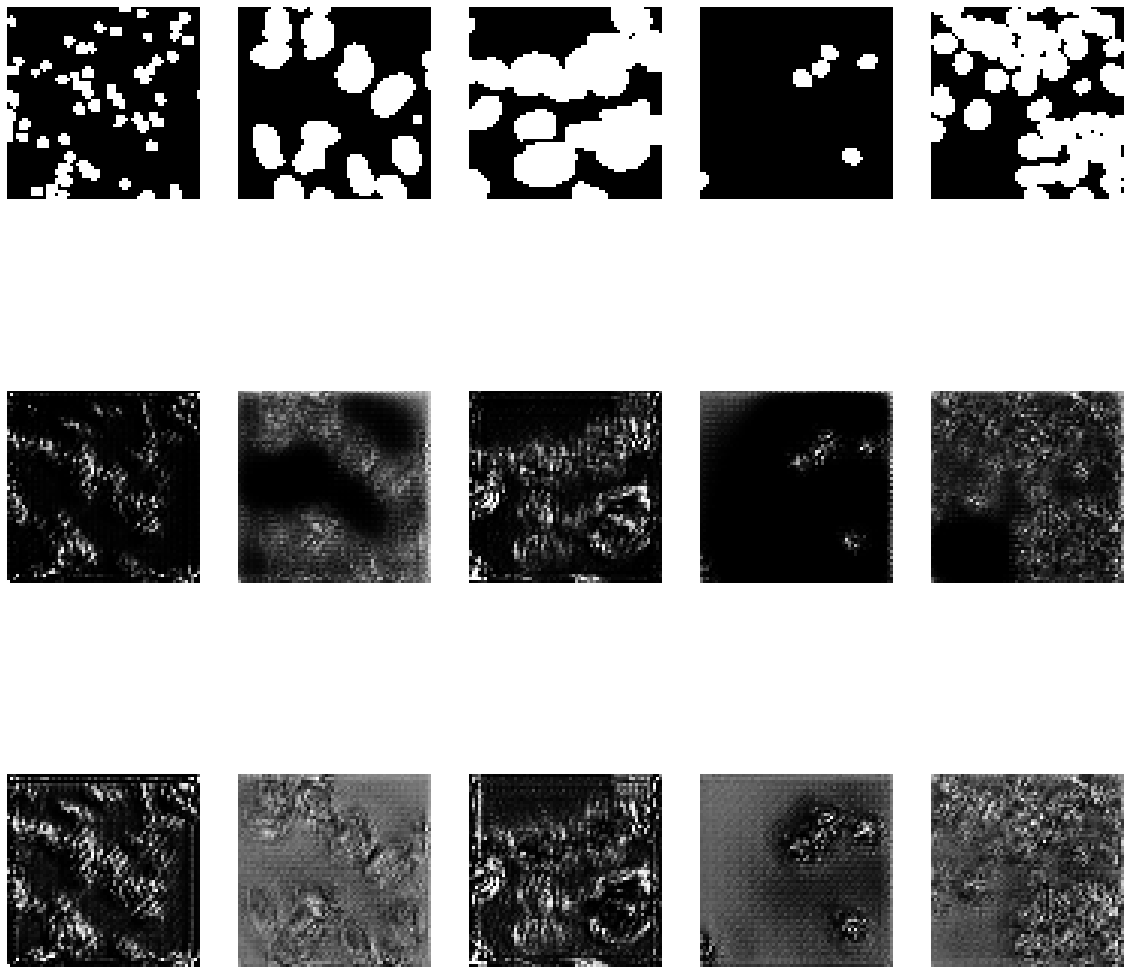

In [25]:
# Here we add data augmentation to improve the results
datagen = ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

# fits the model on batches with real-time data augmentation:
model.fit_generator(datagen.flow(X_train, Y_train, batch_size=32),steps_per_epoch=len(X_train), epochs=epochs)
# model.fit(datagen.flow(X_train, Y_train, batch_size=32),steps_per_epoch=len(X_train), epochs=epochs)

Y_pred_augmented = model.predict(X_test)

#plt.figure(figsize = (20,20))
#for i in range(5):
#  plt.subplot(2,5,i+1)
#  plt.imshow(X_test[i, :, :, :])
#  plt.axis('off')
#plt.show() 


plt.figure(figsize = (20,20))
for i in range(5):
  plt.subplot(3,5,i+1)
  plt.imshow(Y_test[i, :, :, 0],cmap='gray')
  plt.axis('off')
#plt.show() 
#plt.figure(figsize = (20,20))
for i in range(5):
  plt.subplot(3,5,i+1+5)
  plt.imshow(Y_pred[i, :, :, 0],cmap='gray')
  plt.axis('off')
#plt.show() 
#plt.figure(figsize = (20,20))
for i in range(5):
  plt.subplot(3,5,i+1+10)
  plt.imshow(Y_pred_augmented[i, :, :, 0],cmap='gray')
  plt.axis('off')
plt.show()  
